In [2]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import dbconfig as db

engine = sqlalchemy.engine_from_config(db.config, prefix='db.')

# How often is the trace ending with RELAY_COMMAND_END?

Let's query the database and get the last cell for every example. We can do this very quickly using PostgreSQL's WINDOW:

In [48]:
query_last_cells = """SELECT DISTINCT ON (exampleid)
  last_value(t_trace) OVER wnd AS end_time,
  last_value(command) OVER wnd AS last_command,
  exampleid
 FROM raw.frontpage_traces
 WINDOW wnd AS (
   PARTITION BY exampleid ORDER BY t_trace
   ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
 );"""

In [50]:
df_finalcmd = pd.read_sql(query_last_cells, engine)

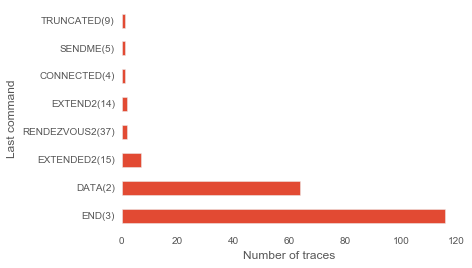

In [111]:
ax = df_finalcmd['last_command'].value_counts().plot(kind='barh')
ax.set_xlabel('Number of traces')
ax.set_ylabel('Last command')
ax.grid(False)
ax.set_frame_on(False)

Compute percent of my examples where the trace ends with END:

In [52]:
df_finalcmd['last_command'].value_counts()['END(3)'] / df_finalcmd['last_command'].value_counts().sum() * 100

59.793814432989691

So ~60% of the traces are ending in END. These traces were collected with a time of 15 seconds. 

# Perhaps we should make the time to wait longer? 

We can determine if traces are indeed being cut off by looking at the distribution of trace duration. 

In [23]:
query_duration_dist = """SELECT DISTINCT ON (exampleid)
  first_value(t_trace) OVER wnd AS start_time,
  last_value(t_trace) OVER wnd AS end_time,
  last_value(t_trace) OVER wnd - first_value(t_trace) OVER wnd AS duration,
  exampleid
 FROM raw.frontpage_traces
 WINDOW wnd AS (
   PARTITION BY exampleid ORDER BY t_trace
   ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
 );"""

In [24]:
df = pd.read_sql(query_duration_dist, engine)

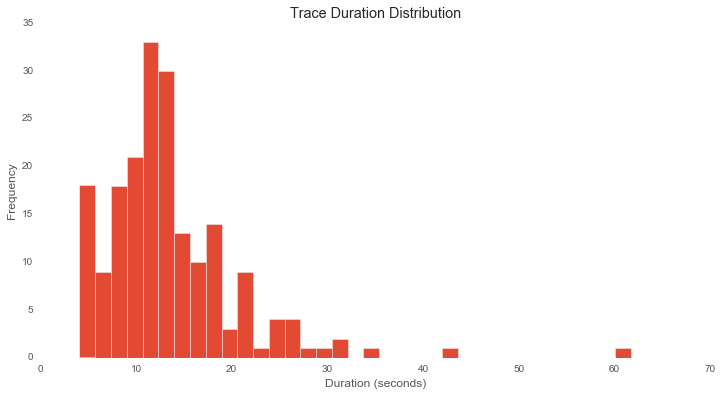

In [47]:
ax = df['duration'].plot(kind='hist', bins=35, title='Trace Duration Distribution', figsize=(12,6))
ax.set_xlabel('Duration (seconds)')
ax.grid(False)
ax.set_frame_on(False)

In [42]:
df['duration'].mean()

13.529671624226804

In [44]:
df['duration'].std()

7.0964987113712175

Looks like there is a bit of a pileup around 15 seconds and then a long tail. 

Out of curiousity, let's see where our traces that do not terminate with END are in this distribution. 

In [57]:
df_cmd = df_finalcmd.drop(['end_time'], axis=1)

In [59]:
# Merge together these two DataFrames
df_joined = pd.merge(df_cmd, df, on='exampleid')

In [64]:
df_joined['Terminated with END'] = df_joined['last_command'].map(lambda x: True if x == 'END(3)' else False)

In [76]:
df_int = df_joined.drop(['start_time', 'end_time', 'last_command', 'exampleid'], axis=1)

In [78]:
df_end = df_int[df_int['Terminated with END'] == True]
df_not_end = df_int[df_int['Terminated with END'] == False]

In [90]:
df_stackedhist = pd.DataFrame({'Terminates with END': df_end.duration, 
                               'Does not terminate with END': df_not_end.duration})

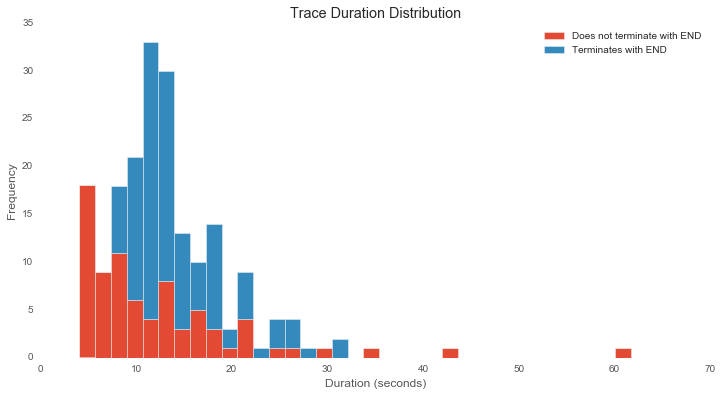

In [96]:
ax = df_stackedhist.plot.hist(stacked=True, bins=35, title='Trace Duration Distribution', figsize=(12,6))
ax.set_xlabel('Duration (seconds)')
ax.grid(False)
ax.set_frame_on(False)

In [97]:
df_end.duration.mean()

14.47509769827586

In [98]:
df_end.duration.std()

4.9944796861214025

In [99]:
df_not_end.duration.mean()

12.123653360256409

In [100]:
df_not_end.duration.std()

9.2532900735997323